In [1]:
!mkdir -p ./kaggle
!cp kaggle.json ./kaggle/
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation
from keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax

In [3]:
folder_names = os.listdir('/content/train')
folder_names

['fear', 'neutral', 'surprise', 'sad', 'happy', 'disgust', 'angry']

In [4]:
def count_files_in_directory(directory):
    folder_file_counts = {}
    for folder_name in folder_names:
        folder_path = os.path.join(directory, folder_name)

        if os.path.isdir(folder_path):
            file_count = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])
            folder_file_counts[folder_name] = file_count

    return folder_file_counts

In [5]:
train_files_count = count_files_in_directory('/content/train')
test_files_count = count_files_in_directory('/content/test')
print(train_files_count)
print(test_files_count)

{'fear': 4097, 'neutral': 4965, 'surprise': 3171, 'sad': 4830, 'happy': 7215, 'disgust': 436, 'angry': 3995}
{'fear': 1024, 'neutral': 1233, 'surprise': 831, 'sad': 1247, 'happy': 1774, 'disgust': 111, 'angry': 958}


In [6]:
def show_files_count(file_counts):
    folders = list(file_counts.keys())
    counts = list(file_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(folders, counts, color='blue')
    plt.xlabel('Emotion class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images for Each Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

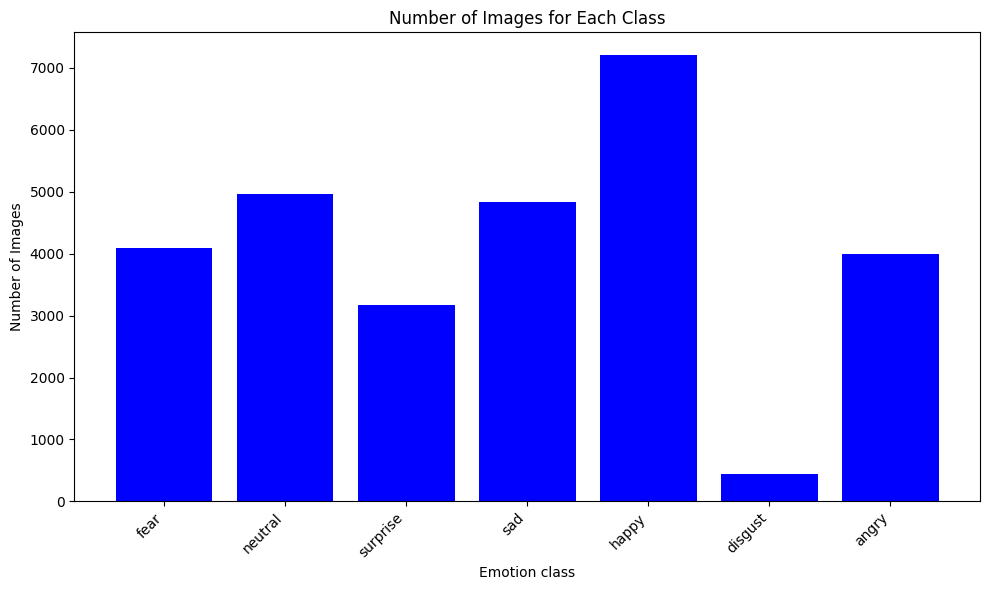

In [7]:
show_files_count(train_files_count)

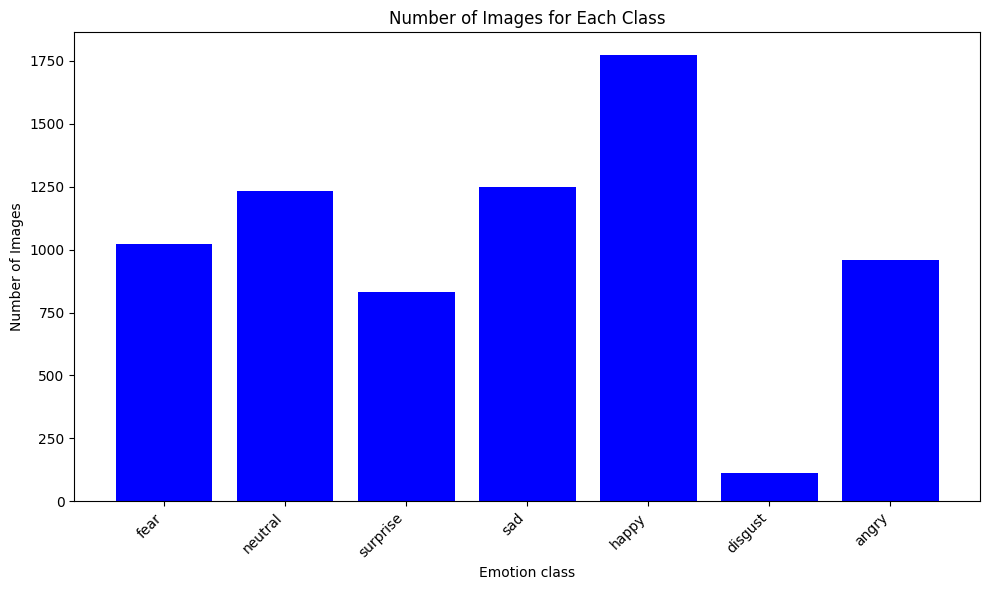

In [8]:
show_files_count(test_files_count)

(48, 48)


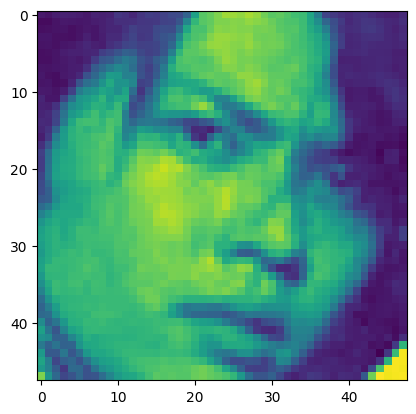

In [9]:
import random as rd
import matplotlib.image as image
files = os.listdir('/content/train/angry')
random_file = rd.choice(files)
random_file_path = os.path.join('/content/train/angry/',random_file)
img = image.imread(random_file_path)
print(img.shape)
plt.imshow(img)
plt.show()

In [10]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [11]:
img_width, img_height, batch_size, epochs, num_classes = 48, 48, 64, 10, 7

In [12]:
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [14]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

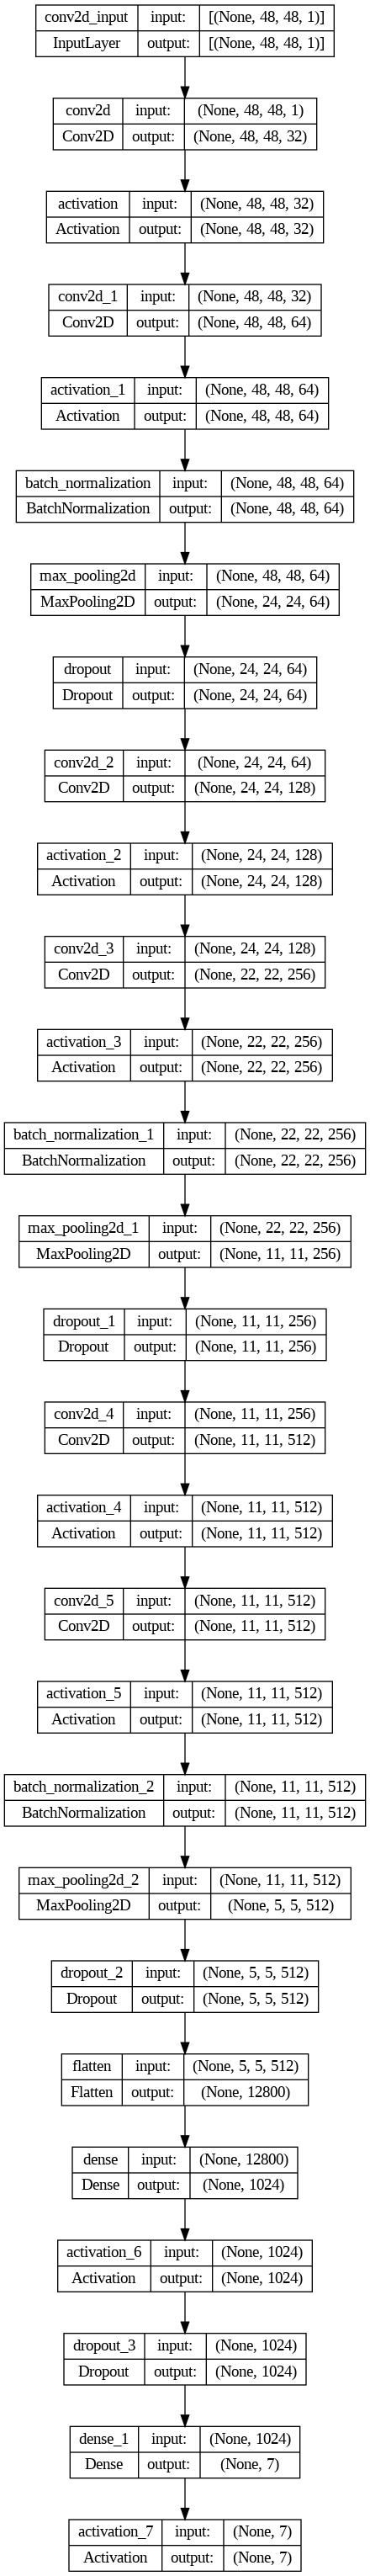

In [16]:
plot_model(model,show_shapes=True,show_layer_names=True,to_file='architecture.png')

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1
train_steps_per_epoch, validation_steps_epoch, test_steps_epoch

(359, 90, 113)

In [19]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,patience=3,
                          verbose=1,restore_best_weights=True)

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=earlystop)

Epoch 1/10
359/359 [==============================] - 49s 92ms/step - loss: 12.4507 - accuracy: 0.2776 - val_loss: 12.7010 - val_accuracy: 0.1418
Epoch 2/10
359/359 [==============================] - 28s 78ms/step - loss: 10.2915 - accuracy: 0.3521 - val_loss: 9.4079 - val_accuracy: 0.3928
Epoch 3/10
359/359 [==============================] - 27s 76ms/step - loss: 8.3030 - accuracy: 0.3902 - val_loss: 7.4429 - val_accuracy: 0.4287
Epoch 4/10
359/359 [==============================] - 25s 69ms/step - loss: 6.5816 - accuracy: 0.4246 - val_loss: 5.9222 - val_accuracy: 0.4515
Epoch 5/10
359/359 [==============================] - 26s 72ms/step - loss: 5.2010 - accuracy: 0.4561 - val_loss: 4.5965 - val_accuracy: 0.4874
Epoch 6/10
359/359 [==============================] - 25s 70ms/step - loss: 4.1400 - accuracy: 0.4895 - val_loss: 3.6747 - val_accuracy: 0.5250
Epoch 7/10
359/359 [==============================] - 25s 69ms/step - loss: 3.3526 - accuracy: 0.5170 - val_loss: 3.0976 - val_accura

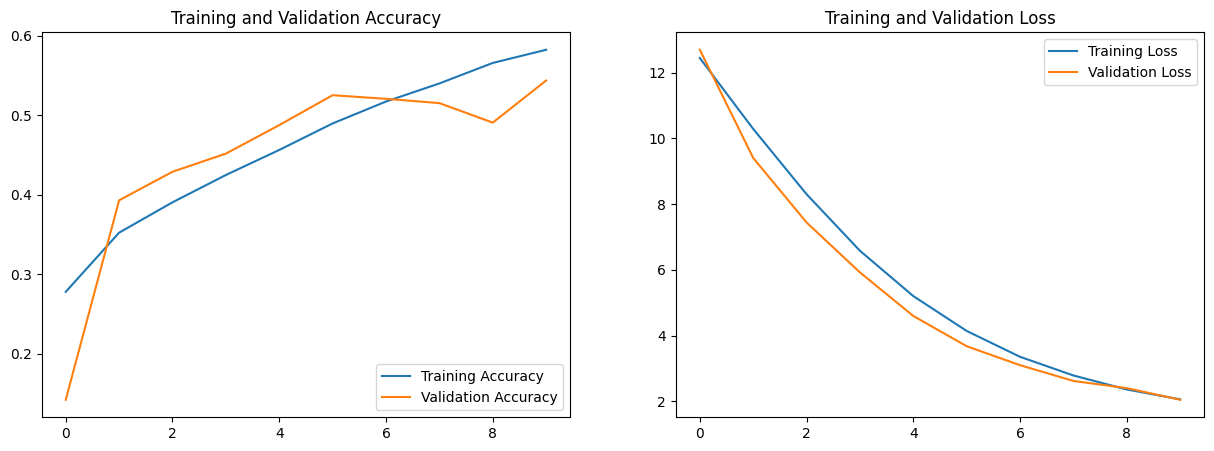

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(accuracy))
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("Training accuracy = {:.2f} , Testing accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 30ms/step - loss: 2.0387 - accuracy: 0.5507
Training accuracy = 62.15 , Testing accuracy = 55.07


113/113 [==============================] - 6s 49ms/step


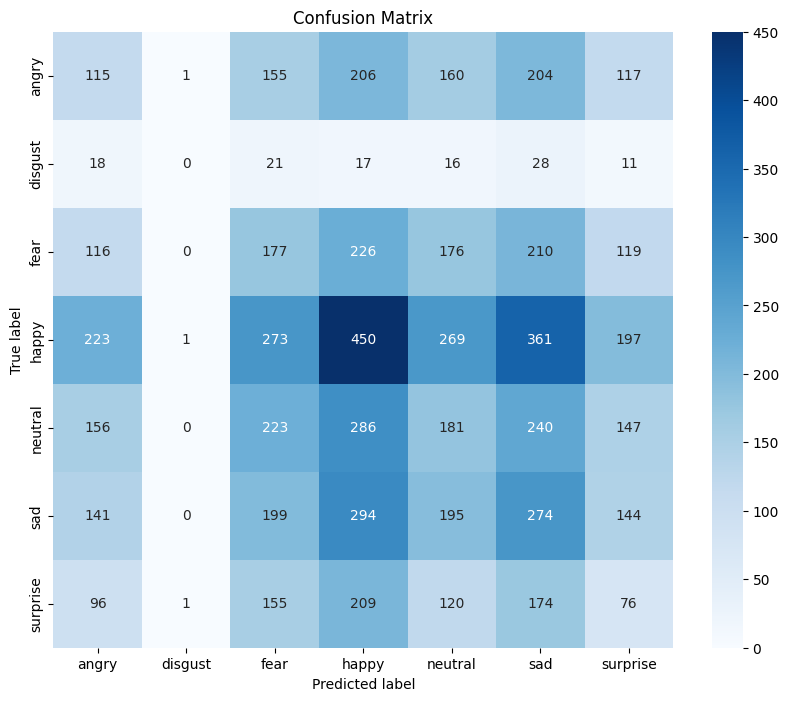

In [23]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.12      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.17      0.16      1024
       happy       0.27      0.25      0.26      1774
     neutral       0.16      0.15      0.15      1233
         sad       0.18      0.22      0.20      1247
    surprise       0.09      0.09      0.09       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.18      7178



In [25]:
model.save('custom_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


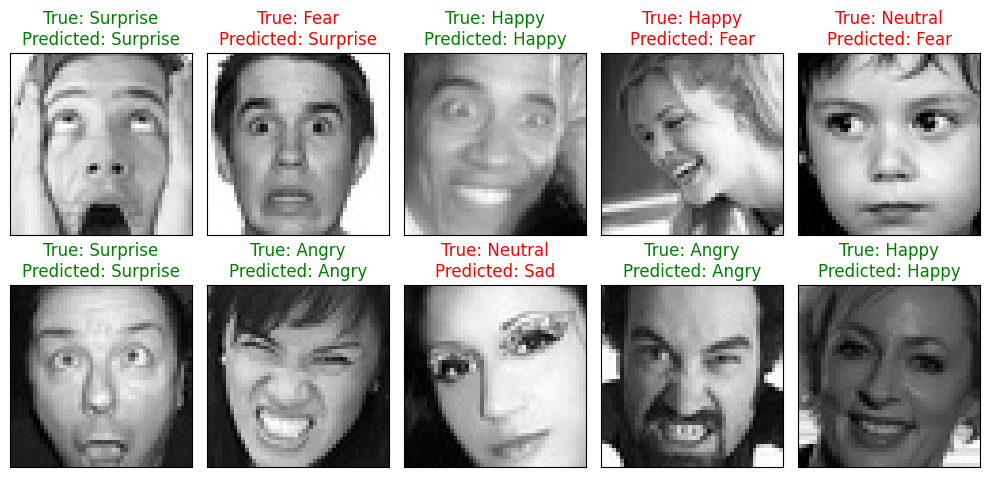

In [29]:
folder_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
batch_size = test_generator.batch_size
Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]
    ax.imshow(Random_Img.squeeze(), cmap='gray')
    color = "green" if folder_names[Random_Img_Label] == folder_names[Model_Prediction] else "red"
    ax.set_title(f"True: {folder_names[Random_Img_Label]}\nPredicted: {folder_names[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()